In [ ]:
# Copyright 2013-2016 The Salish Sea NEMO Project and
# The University of British Columbia

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
"""Functions for working with geographical data and model results.
"""

'Functions for working with geographical data and model results.\n'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import tidetools
import netCDF4 as nc
import pdb
%matplotlib inline

In [4]:
def distance_along_curve(lons, lats):
    """Calculate cumulative distance in km between points in lons, lats

    :arg lons: 1D array of longitude points.
    :type lons: :py:class:`numpy.ndarray`

    :arg lats: 1D array of latitude points.
    :type lats: :py:class:`numpy.ndarray`

    :returns: Cummulative point-by-point distance along track in km.
    :rtype: :py:class:`numpy.ndarray`
    """
    dist = np.cumsum(haversine(lons[1:], lats[1:], lons[:-1], lats[:-1]))
    return np.insert(dist, 0, 0)

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.

    Reference: http://www.movable-type.co.uk/scripts/latlong.html

    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`

    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`

    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`

    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`

    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [177]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid = 'NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon':0.0052, 'tol_lat':0.00189},
        #'NEMO': {'tol_lon':0.0042, 'tol_lat':0.00139},
        'GEM2.5': {'tol_lon':0.016, 'tol_lat':0.011},
}):
    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    i, j = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'], model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'], model_lats < lat + tols[grid]['tol_lat']))))
    if j.size > 1 or i.size > 1:
        raise ValueError(
            'Multiple model points found. tol_lon/tol_lat too big.'
        )
    elif not j or not i:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    if land_mask is not None and land_mask[i,j]: 
        xmax, ymax = land_mask.shape
        max_search_dist = int(len(model_lats)/4)
        closest_point = None
        x = 0
        y = 0
        dx = 0
        dy = -1
        while x <= max_search_dist:
            if (x + i) >= 0 and (x + i) < xmax and (y + j) >= 0 and (y + j) < ymax:
                if not land_mask[x + i,y + j]:
                    #dist = haversine(lon,lat,model_lons[x+i, y+j],  model_lats[x+i, y+j])
                    dist = (x**2 + y**2)**0.5
                    if closest_point is None:
                        min_dist = dist
                        closest_point = (i+x,j+y)
                        if dist < max_search_dist:
                            max_search_dist = int(dist)
                    elif dist < min_dist:
                        print("Dist: " + str(dist))
                        print("Point: " + str((i +x,j + y)))
                        min_dist = dist
                        closest_point = (i + x,j +y)
            if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
                dx, dy = -dy, dx
            x, y = x+dx, y+dy
        if closest_point is None:
            raise ValueError(
                'No model point found on water'
            )
        else:
            i,j = closest_point
    return j,i
        

In [1]:
def find_model_point(lon, lat, X, Y, tol_lon=0.016, tol_lat=0.011):
    """Finds a model grid point close to a specified latitude and longitude.
    Should be used for non-NEMO grids like the atmospheric forcing grid.

    :arg lon: The longitude we are trying to match.
    :type lon: float

    :arg lat: The latitude we are trying to match.
    :type lat: float

    :arg X: The model longitude grid.
    :type X: numpy array

    :arg Y: The model latitude grid.
    :type Y: numpy array

    :arg tol_lon: tolerance on grid spacing for longitude
    :type tol_lon: float

    :arg tol_lat: tolerance on grid spacing for latitude
    :type tol_lat: float

    :returns: j-index and i-index of the closest model grid point.
    """

    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    j, i = np.where(
        np.logical_and(
            (np.logical_and(X > lon - tol_lon, X < lon + tol_lon)),
            (np.logical_and(Y > lat - tol_lat, Y < lat + tol_lat))))

    if j.size > 1 or i.size > 1:
        raise ValueError(
            'Multiple model points found. tol_lon/tol_lat too big.'
        )
    elif not j or not i:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    return j, i

In [2]:
def find_closest_model_point(lon, lat, X, Y, bathy, lon_tol=0.0052,
                             lat_tol=0.00189, allow_land=False):
    """Returns the grid co-ordinates of the closest non-land model point
    to a specified lon/lat.

    e.g. yind, xind = find_closest_model_point(-125.5,49.2,X,Y,bathy)
    where bathy, X and Y are returned from get_bathy_data(grid).
    yind is the y-index(latitude), xind is the x-index(longitude)

    :arg lon: specified longitude
    :type lon: float

    :arg lat: specified latitude
    :type lat: float

    :arg X: specified model longitude
    :type X: numpy array

    :arg Y: specified model latitude
    :type Y: numpy array

    :arg bathy: model bathymetry
    :type bathy: numpy array

    :arg lon_tol: tolerance value for seaching in longitude
    :type lon_tol: float

    :arg lat_tol: tolerance value for searching in latitude
    :type lat_tol: float

    :arg allow_land: whether code should return a land point or closest
                     water point
    :type allow_land: boolean

    :returns: yind, xind
    """
    # Tolerance for searching for grid points
    # (default is approx. distances between adjacent grid points)
    tol1 = lon_tol   # lon
    tol2 = lat_tol   # lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))

    # check size of arrays so we don't go out of bounds in our search
    xmax, ymax = bathy.shape
    if np.size(x1) != 0:
        x1 = x1[0]
        y1 = y1[0]
        # What if more than one point is returned from this search?
        # Just take the first one...
        #
        # If x1,y1 is masked, search 3x3 grid around.
        # If all those points are masked, search 4x4 grid around, etc.
        for ii in np.arange(1, 100):
            if bathy.mask[x1, y1] and not allow_land:
                for i in np.arange(max(0, x1-ii), min(xmax, x1+ii+1)):
                    for j in np.arange(max(0, y1-ii), min(ymax, y1+ii+1)):
                        if not bathy.mask[i, j]:
                            break
                    if not bathy.mask[i, j]:
                        break
                if not bathy.mask[i, j]:
                    break
            else:
                i = x1
                j = y1
    else:
            i = []
            j = []
    return i, j

In [7]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

In [8]:
len(Y)

898

In [179]:
#print(find_closest_model_point(-124, 48, model_lons = X, model_lats = Y, grid = 'Test', tols = {"Test":{'tol_lat':0.002658843994140625, 'tol_lon':0.0009403228759765625}}, land_mask = bathy.mask))
lon, lat = -124.35, 48.85

closest_point = find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
print(closest_point)

Dist: 71.42128534267638
Point: (array([403]), array([56]))
(array([56]), array([403]))


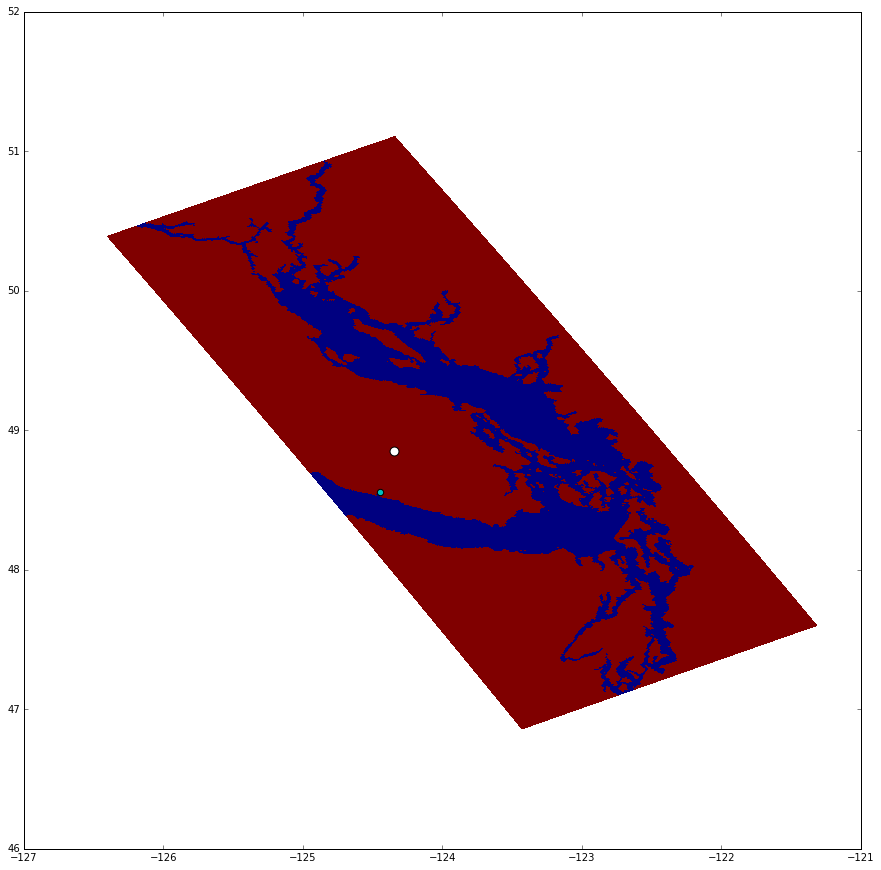

In [180]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.pcolormesh(X,Y, (bathy.mask).astype('int'))
plt.scatter([lon], [lat], c = "w" , s =80)
plt.scatter([X[tuple(reversed(closest_point))]], [Y[tuple(reversed(closest_point))]], c = "c" , s =40)
#plt.scatter([X[109,143]], [Y[109,143]], c = "c" , s =40)


In [37]:
bathy.mask[26,46]

True